In [112]:
import pandas as pd
import glob
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

Reading my clean data from previous notebook

In [113]:
df = pd.read_csv('data/Clean_data.csv')
df

,HomeOdds,DrawOdds,AwayOdds,Winner,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HomeTeamLP,AwayTeamLP,HTGD,ATGD,DiffFormPts,DiffLP
0,1.44,4.00,7.50,1,1.000000,0.250000,W,L,D,L,L,D,11.0,18.0,0.000000,-1.000000,0.750000,-7.0
1,2.25,3.20,3.10,1,0.250000,1.500000,L,L,D,W,W,L,16.0,7.0,-0.500000,0.250000,-1.250000,9.0
2,2.00,3.20,3.75,1,1.500000,0.750000,W,W,L,D,D,D,17.0,18.0,0.000000,0.000000,0.750000,-1.0
3,1.28,5.00,10.00,1,2.250000,0.750000,W,W,W,L,W,L,2.0,12.0,1.000000,-0.500000,1.500000,-10.0
4,9.00,4.33,1.36,-1,0.500000,2.250000,D,L,D,W,W,W,18.0,1.0,-0.250000,2.000000,-1.750000,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,1.18,8.00,19.00,1,2.117647,0.705882,W,W,L,W,L,L,3.0,7.0,0.823529,-1.000000,0.470588,-4.0
3171,1.64,3.90,6.00,1,1.235294,0.823529,D,L,L,W,L,W,14.0,18.0,-0.176471,-0.882353,-0.411765,-4.0
3172,7.50,4.50,1.50,-1,1.235294,2.000000,L,W,W,W,L,W,15.0,5.0,-0.176471,1.176471,0.000000,10.0
3173,1.57,4.50,6.00,1,2.470588,1.529412,W,W,W,W,D,D,4.0,2.0,1.647059,0.117647,0.529412,2.0


# Modeling 

- Run multiple models
- Pick the best one and explore hyper-parameters

### Train Test Split 

- Train and test my data
- Hold 100 matches to compare at the end 

In [114]:
X = df.drop(columns = 'Winner')
y = df['Winner']

X_t, X_val, y_t, y_val = train_test_split(X, y, test_size=100, shuffle=False,
                                                  random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.1, shuffle=False,
                                                  random_state=42)

### Baseline Model for Home Team

In [115]:
y_train.value_counts(normalize=True)

 1    0.458619
-1    0.286231
 0    0.255150
Name: Winner, dtype: float64

In [116]:
y_test.value_counts(normalize=True)

 1    0.451299
-1    0.282468
 0    0.266234
Name: Winner, dtype: float64

### Baseline Model for Team with Best Odds

In [117]:
# Function 2
def find_best_odds(X, y):
    '''
    Function to map the teams to the lowest odds. And see if the winning 
    team had the lowest odds. And creates a column to see if it was correct
    or not
    '''
    odds_map = {'HomeOdds' : 1,
            'AwayOdds' : -1,
            'DrawOdds' : 0}
    odds = X[['HomeOdds', 'DrawOdds', 'AwayOdds']]
    odds['lowest_odds'] = odds.idxmin(axis=1)
    odds['winner'] = y
    odds['lowest_odds'] = odds['lowest_odds'].map(odds_map)
    odds['odds_correct'] = odds['lowest_odds'] == odds['winner']
    return odds 

In [118]:
train_odds = find_best_odds(X_train, y_train)
test_odds = find_best_odds(X_test, y_test)
val_odds = find_best_odds(X_val, y_val)

In [119]:
train_odds['odds_correct'].value_counts(normalize=True)

True     0.546802
False    0.453198
Name: odds_correct, dtype: float64

In [120]:
test_odds['odds_correct'].value_counts(normalize=True)

True     0.581169
False    0.418831
Name: odds_correct, dtype: float64

## Pipeline

- creating a seperate cat cols and num cols
- scaling and ohe
- creating pipeline to make models

In [121]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

In [122]:
cat_cols

Index(['HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3'], dtype='object')

In [123]:
num_cols

Index(['HomeOdds', 'DrawOdds', 'AwayOdds', 'HTP', 'ATP', 'HomeTeamLP',
       'AwayTeamLP', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP'],
      dtype='object')

In [124]:
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

num_transformer = Pipeline(steps = [
    ('num_imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

In [125]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

## Logistic Regression

In [126]:
lr_clf = dt_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression())
])

In [127]:
lr_clf.fit(X_train, y_train)

print(f'Train Accuracy: {lr_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {lr_clf.score(X_test, y_test)}')

Train Accuracy: 0.563787495482472
Test Accuracy: 0.5551948051948052


In [128]:
lr_pred = lr_clf.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, lr_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, lr_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, lr_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, lr_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.5551948051948052
-------------------
Test Precision Score: 0.5551948051948052
-------------------
Test Recall Score: 0.5551948051948052
-------------------
Test F1_score: 0.5551948051948052
-------------------


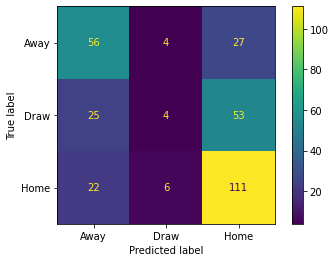

In [129]:
plot_confusion_matrix(lr_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

## Decision Tree

In [130]:
dt_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier())
])

In [131]:
dt_clf.fit(X_train, y_train)

print(f'Train Accuracy: {dt_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {dt_clf.score(X_test, y_test)}')

Train Accuracy: 1.0
Test Accuracy: 0.44805194805194803


In [132]:
dt_pred = dt_clf.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, dt_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, dt_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, dt_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, dt_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.44805194805194803
-------------------
Test Precision Score: 0.44805194805194803
-------------------
Test Recall Score: 0.44805194805194803
-------------------
Test F1_score: 0.4480519480519481
-------------------


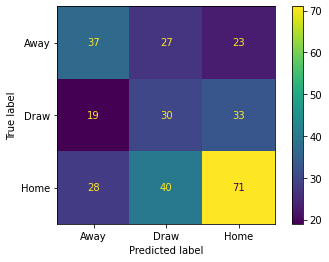

In [133]:
plot_confusion_matrix(dt_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

## Gaussin

In [134]:
nb_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('nb', GaussianNB())
])

In [135]:
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)

print(f'Train Accuracy: {nb_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {nb_clf.score(X_test, y_test)}')

Train Accuracy: 0.5272858691723888
Test Accuracy: 0.5714285714285714


In [136]:
precision_score(y_test, nb_pred, average='micro')

0.5714285714285714

In [137]:


print(f'Test Accuracy Score: {accuracy_score(y_test, nb_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, nb_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, nb_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, nb_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.5714285714285714
-------------------
Test Precision Score: 0.5714285714285714
-------------------
Test Recall Score: 0.5714285714285714
-------------------
Test F1_score: 0.5714285714285714
-------------------


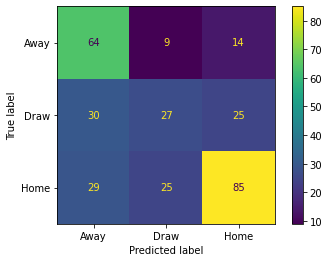

In [138]:
plot_confusion_matrix(nb_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

## KNN

In [139]:
knn_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

In [140]:
knn_clf.fit(X_train, y_train)

print(f'Train Accuracy: {knn_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {knn_clf.score(X_test, y_test)}')

Train Accuracy: 0.6396819660281894
Test Accuracy: 0.4253246753246753


In [141]:
knn_pred = knn_clf.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, knn_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, knn_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, knn_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, knn_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.4253246753246753
-------------------
Test Precision Score: 0.4253246753246753
-------------------
Test Recall Score: 0.4253246753246753
-------------------
Test F1_score: 0.42532467532467527
-------------------


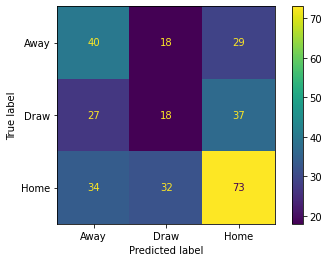

In [142]:
plot_confusion_matrix(knn_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

## XGB

In [143]:
xgb_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier())
])

In [144]:
xgb_clf.fit(X_train, y_train)

print(f'Train Accuracy: {xgb_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {xgb_clf.score(X_test, y_test)}')

Train Accuracy: 1.0
Test Accuracy: 0.538961038961039


In [145]:
xgb_pred = xgb_clf.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, xgb_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, xgb_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, xgb_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, xgb_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.538961038961039
-------------------
Test Precision Score: 0.538961038961039
-------------------
Test Recall Score: 0.538961038961039
-------------------
Test F1_score: 0.538961038961039
-------------------


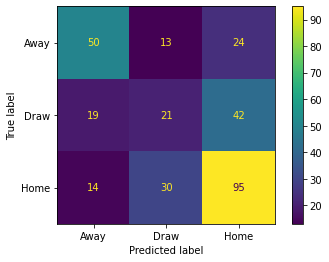

In [146]:
plot_confusion_matrix(xgb_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

## SVC

In [147]:
svc_clf = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

In [148]:
svc_clf.fit(X_train, y_train)

print(f'Train Accuracy: {svc_clf.score(X_train, y_train)}')
print(f'Test Accuracy: {svc_clf.score(X_test, y_test)}')

Train Accuracy: 0.5963136971449223
Test Accuracy: 0.5324675324675324


In [149]:
svc_pred = svc_clf.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, svc_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, svc_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, svc_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, svc_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.5324675324675324
-------------------
Test Precision Score: 0.5324675324675324
-------------------
Test Recall Score: 0.5324675324675324
-------------------
Test F1_score: 0.5324675324675324
-------------------


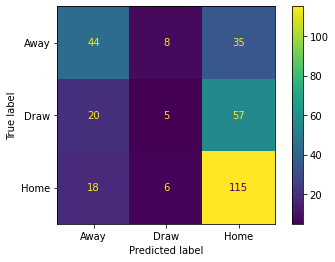

In [150]:
plot_confusion_matrix(svc_clf, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

Best results 

### GridSearchCV 
- Tuning our hyper-parameters
- Finding a good model

In [151]:
params_svc = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel':['linear', 'poly', 'sigmoid', 'rbf']
}

In [152]:
gs_svc = GridSearchCV(svc_clf, params_svc, cv=5, scoring='accuracy')

gs_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['HomeOdds', 'DrawOdds', 'AwayOdds', 'HTP', 'ATP', 'HomeTeamLP',
       'AwayTeamLP', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
               

In [153]:
gs_svc.best_params_

{'svc__C': 1, 'svc__kernel': 'linear'}

In [154]:
print(f'Train Accuracy: {gs_svc.best_estimator_.score(X_train, y_train)}')
print(f'Test Accuracy: {gs_svc.best_estimator_.score(X_test, y_test)}')

Train Accuracy: 0.5561980484279002
Test Accuracy: 0.5714285714285714


In [155]:
svc_gs_pred = gs_svc.best_estimator_.predict(X_test)

print(f'Test Accuracy Score: {accuracy_score(y_test, svc_gs_pred)}')
print('-------------------')
print(f"Test Precision Score: {precision_score(y_test, svc_gs_pred, average='micro')}")
print('-------------------')
print(f"Test Recall Score: {recall_score(y_test, svc_gs_pred, average='micro')}")
print('-------------------')
print(f"Test F1_score: {f1_score(y_test, svc_gs_pred, average='micro')}")
print('-------------------')

Test Accuracy Score: 0.5714285714285714
-------------------
Test Precision Score: 0.5714285714285714
-------------------
Test Recall Score: 0.5714285714285714
-------------------
Test F1_score: 0.5714285714285714
-------------------


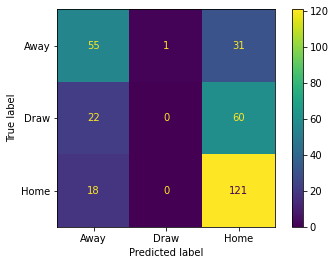

In [156]:
plot_confusion_matrix(gs_svc.best_estimator_, X_test, y_test,display_labels=['Away', 'Draw', 'Home'])

### 100 games 

Ran my model on the 100 games that weren't scaled on 

In [157]:
y_val.value_counts()

 1    47
-1    35
 0    18
Name: Winner, dtype: int64

In [158]:
len(y_val)

100

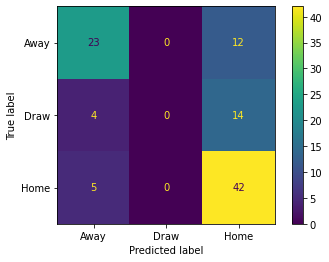

In [159]:
plot_confusion_matrix(gs_svc.best_estimator_, X_val, y_val, display_labels=['Away', 'Draw', 'Home'])

In [160]:
svc_pred_val = gs_svc.best_estimator_.predict(X_val)

print(f'Hold Out Accuracy Score: {accuracy_score(y_val, svc_pred_val)}')
print('-------------------')
print(f"Hold Out Precision Score: {precision_score(y_val, svc_pred_val, average='micro')}")
print('-------------------')
print(f"Hold Out Recall Score: {recall_score(y_val, svc_pred_val, average='micro')}")
print('-------------------')
print(f"Hold Out F1_score: {f1_score(y_val, svc_pred_val, average='micro')}")
print('-------------------')

Hold Out Accuracy Score: 0.65
-------------------
Hold Out Precision Score: 0.65
-------------------
Hold Out Recall Score: 0.65
-------------------
Hold Out F1_score: 0.65
-------------------


In [161]:
val_odds['odds_correct'].value_counts(normalize=True)

True     0.61
False    0.39
Name: odds_correct, dtype: float64

In [162]:
y_val.value_counts(normalize=True)

 1    0.47
-1    0.35
 0    0.18
Name: Winner, dtype: float64

- over predicting home team win   
- currently not predicting a draw
- Better prediction than baseline models